In [1]:
import utulek
import torch
import numpy as np

torch.manual_seed(0)

In [2]:
hps = {
    "batch_size": 100,
    "epochs": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

In [3]:
class Cifar10Dataset(torch.utils.data.Dataset):
    def __init__(self, split):
        self.X, self.Y = utulek.fetch_tfds_img_ds("cifar10", split)
        self.X, self.Y = self.X.astype(np.float32), self.Y.astype(np.int64)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [4]:
dss = {
    "cifar10": (
        Cifar10Dataset("train"),
        Cifar10Dataset("test")
    )
}

In [5]:
dss["c10-dl"] = (
    torch.utils.data.DataLoader(dss["cifar10"][0], batch_size=hps["batch_size"]),
    torch.utils.data.DataLoader(dss["cifar10"][1], batch_size=hps["batch_size"])
)

for X, Y in dss["c10-dl"][0]:
    print(f"X \in {X.shape}")
    print(f"Y \in {Y.shape} of {Y.dtype}")
    break

X \in torch.Size([100, 32, 32, 3])
Y \in torch.Size([100]) of torch.int64


In [6]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(32**2*3, 4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 10)
        )

    def forward(self, X):
        X = self.flatten(X)
        logits = self.linear_relu_stack(X)
        return logits


print(model := NeuralNetwork().to(hps["device"]))

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4096, out_features=10, bias=True)
  )
)


In [7]:
import time


loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=3e-4)
rs = {
    "to": 0,
    "step": 0,
    "test": 0
}


def train(dataloader, model, loss_fn, optimizer):
    model.train()
    for _, (X, Y) in enumerate(dataloader):
        tst = time.process_time()
        X, Y = X.to(hps["device"]), Y.to(hps["device"])
        rs["to"] += time.process_time() - tst

        tst = time.process_time()
        pred = model(X)
        loss = loss_fn(pred, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        rs["step"] += time.process_time() - tst


def test(dataloader, model, loss_fn, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(hps["device"]), Y.to(hps["device"])
            pred = model(X)
            test_loss += loss_fn(pred, Y).item()
            correct += (pred.argmax(1) == Y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"{epoch}: {(100*correct):>0.1f}% | {test_loss:>8f}")

In [8]:
%%time
for epoch in range(hps["epochs"]):
    train(dss["c10-dl"][0], model, loss_fn, optimizer)
    tst = time.process_time()
    test(dss["c10-dl"][1], model, loss_fn, epoch)
    rs["test"] += time.process_time() - tst

print(rs)

0: 10.7% | 2.286387
1: 13.4% | 2.273123
2: 16.2% | 2.260216
3: 18.6% | 2.247315
4: 20.5% | 2.234203
5: 22.1% | 2.220741
6: 23.4% | 2.206887
7: 24.0% | 2.192623
8: 25.1% | 2.178027
9: 25.7% | 2.163262
10: 26.4% | 2.148497
11: 26.9% | 2.133916
12: 27.5% | 2.119695
13: 28.0% | 2.105972
14: 28.3% | 2.092843
15: 28.8% | 2.080372
16: 29.1% | 2.068580
17: 29.3% | 2.057469
18: 29.5% | 2.047017
19: 29.7% | 2.037175
20: 29.9% | 2.027883
21: 30.2% | 2.019092
22: 30.2% | 2.010763
23: 30.4% | 2.002854
24: 30.5% | 1.995336
25: 30.8% | 1.988178
26: 30.9% | 1.981352
27: 30.9% | 1.974840
28: 31.2% | 1.968618
29: 31.5% | 1.962664
30: 31.6% | 1.956958
31: 31.8% | 1.951482
{'to': 44.76145411700052, 'step': 30.655695622000593, 'test': 12.977295304999977}
CPU times: user 1min 47s, sys: 1.06 s, total: 1min 48s
Wall time: 1min 47s


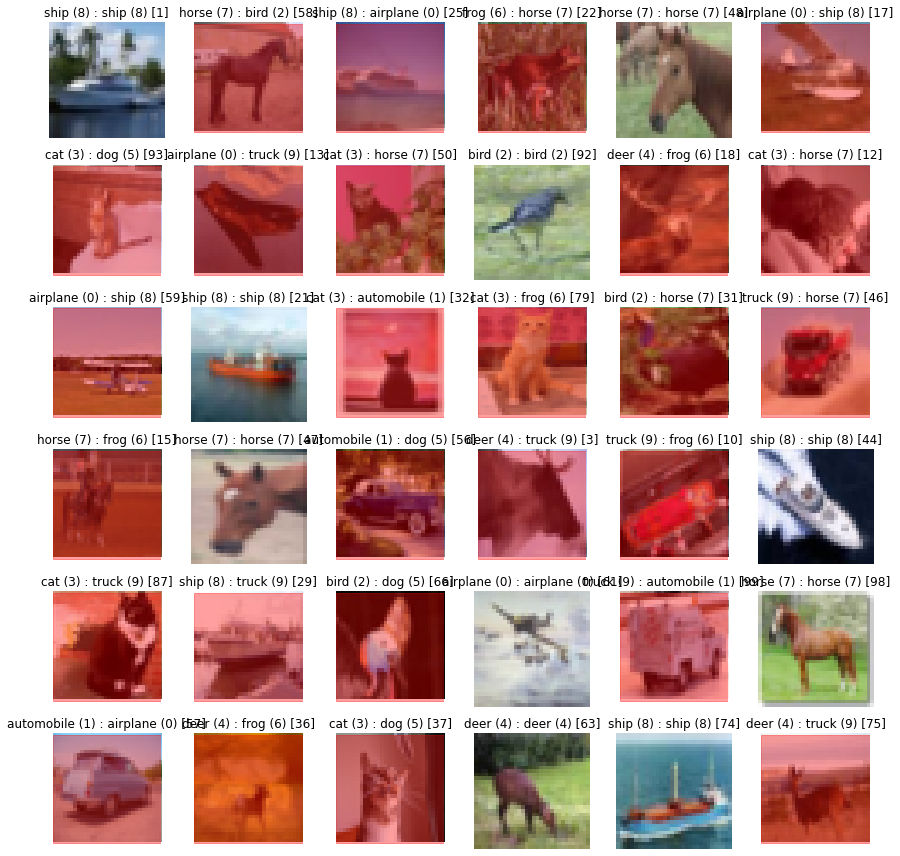

In [9]:
for X, Y in dss["c10-dl"][0]:
    pred = model(X.to(hps["device"])).argmax(axis=1).cpu()
    utulek.show_img_ds(X, Y, pred, labels=utulek.fetch_tfds_img_ds_labels("cifar10"), shape=(6, 6))
    break